# SNR Tolerance

This Notebook serves the purpose of showing how the performance of QRS detection algorithms decreases if noise is added to the data. We use the WFDB XQRS algorithm for detecting QRS complexes and the MIT-BIH NSTDB electrode motion noise template.

## Preparation

Run the following command in order to fetch the MIT-BIH Arrhythmia Database and the noise templates from the MIT-BIH Noise Stress Test Database:
```shell
./scripts/download_databases.py -d data -k mitdb noises
```

In [1]:
from itertools import product

import sys

from wfdb.processing import xqrs_detect
import wfdb

sys.path.append("../raccoon")

from utils.annotationutils import trigger_points
from utils.evaluationutils import triggers_metrics, sensitivity, f1, ppv
from utils.noiseutils import apply_noise_db

In [2]:
def read_record(path):
    record = wfdb.rdrecord(path)
    annotation = wfdb.rdann(path, 'atr')
    trigger = trigger_points(annotation)
    return record, trigger

def read_records(directory, names):
    records, triggers = [], []
    for name in names:
        path = "/".join([directory, name])
        record, trigger = read_record(path)
        records.append(record)
        triggers.append(trigger)
    return records, triggers

In [3]:
# Clean ECG Signals
signal_dir = "../data/mitdb"
signal_names = ["100", "101", "102", "103", "104"]

# Noise Template (electrode motion, em)
noise_path = "../data/noises/em"

# Desired SNRs in dB
snrs = range(-6, 7)

records, triggers = read_records(signal_dir, signal_names)
noise = wfdb.rdrecord(noise_path).p_signal[:,0]

In [4]:
ses = []
ppvs = []
f1s = []

for snr in snrs:
    signals = [
        apply_noise_db(record.p_signal[:,0], noise, snr)
        for record in records]
    fss = [record.fs for record in records]
    detecteds = [
        xqrs_detect(signal, fs, verbose=False)
        for signal, fs in zip(signals, fss)]
    
    tp, tn, fp, fn = triggers_metrics(triggers, detecteds, 2)
    
    ses.append(sensitivity(tp, fn))
    ppvs.append(ppv(tp, fp))
    f1s.append(f1(tp, fp, fn))

In [5]:
print(snrs)
print(ses)
print(ppvs)
print(f1s)

range(-6, 7)
[0.7782371734636346, 0.8092463822589738, 0.8378124412704379, 0.8642172523961661, 0.8886487502349183, 0.907160308212742, 0.9212554031197143, 0.9349746288291675, 0.9461567374553655, 0.954613794399549, 0.9629768840443526, 0.9681450855102425, 0.9722796466829543]
[0.5718428502382104, 0.6162432915921288, 0.6645300737869867, 0.7151632970451011, 0.7676759477230295, 0.8075282308657465, 0.8393117027651742, 0.8705923527867705, 0.8966960548579571, 0.9190338339062782, 0.9405286343612335, 0.9538048509535271, 0.9646652992727951]
[0.6592636815920399, 0.6996790835601414, 0.74117793757014, 0.7826567951663688, 0.8237446104263751, 0.8544497057131477, 0.8783765622900148, 0.9016356304653165, 0.9207626537423986, 0.9364859882005899, 0.9516203918655399, 0.9609214698750234, 0.9684575065518533]


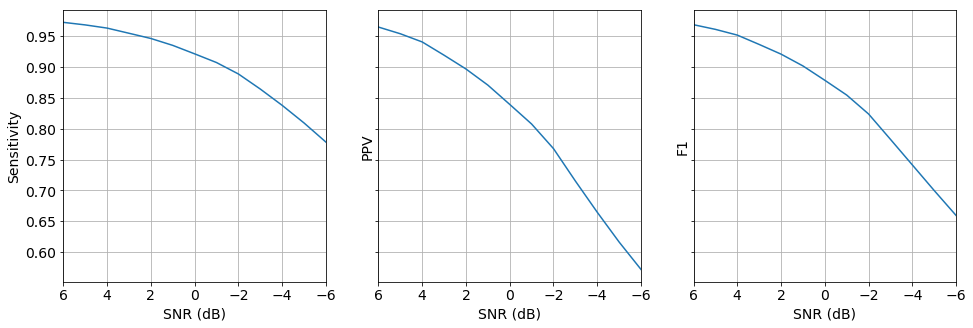

In [23]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

fig.set_size_inches(16, 5)

ax1.plot(snrs, ses)
ax1.grid()
ax1.set_xlim(6, -6)
ax1.set_xlabel("SNR (dB)")
ax1.set_ylabel("Sensitivity")

ax2.plot(snrs, ppvs)
ax2.grid()
ax2.set_xlim(6, -6)
ax2.set_xlabel("SNR (dB)")
ax2.set_ylabel("PPV")

ax3.plot(snrs, f1s)
ax3.grid()
ax3.set_xlim(6, -6)
ax3.set_xlabel("SNR (dB)")
ax3.set_ylabel("F1")

plt.show()

In [24]:
fig.savefig(
    '../../msc-thesis/thesis/images/snr_drop.png',
    bbox_inches = 'tight',
    pad_inches = 0)